# Sample Sankay
- sankay plot to display bks set of cbc metagenomics samples
- goal: use sankay to display fates over time of tagged colonies (that were sequenced) and have number of samples (or preferably numbers of circles) of those colonies at each time point
- https://github.com/davidsjoberg/ggsankey - it should be possible to do numbers, but don't know if i can add in the additional feature of sample to colony?
- https://rpubs.com/techanswers88/sankey-with-own-data-in-ggplot

In [1]:
library(dplyr)
library(tidyverse)
library(ggplot2)
library(tidyr)
library(purrr)
library(stringr)
library(reshape2) 
library(ggsankey)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.2     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.4     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
samplelist<-read.table('../inputs/genohublist_sctld2024.txt', header = FALSE)
colony <- read_csv("/Users/brookesienkiewicz/Documents/sctld/SCTLD_samples/Sample_Data/CBC_ColonyData.csv", show_col_types = FALSE)
sctld_samples <- read.csv("/Users/brookesienkiewicz/Documents/sctld/SCTLD_samples/Sample_Data/CBC_samples.csv")

New names:
• `` -> `...1`


In [3]:
# add colony ids to all dfs
add_colonyid <- function(df) {
    # get transect # 
    df$transect_id <- paste0('T',df$TransectNum)
    # make colony id 
    df$colony_id <- paste(df$transect_id, df$NewTagNum, df$Species,
                                 sep = "_")
    return(df)
}

# apply 
sctld_samples<-add_colonyid(sctld_samples)
colony <- add_colonyid(colony)

In [4]:
colnames(sctld_samples)

[1] "Month_year"                   "Country"                     
 [3] "Location"                     "CollectionDate"              
 [5] "Transect"                     "TransectNum"                 
 [7] "OldTagNum"                    "NewTagNum"                   
 [9] "Species"                      "Time_sampled"                
[11] "Time_processed"               "Sample_type"                 
[13] "SampleNum"                    "Health_status"               
[15] "Sampling_notes"               "Tubelabel_species"           
[17] "Sample_physical_location"     "Extraction_physical_location"
[19] "Date_sequenced"               "Notes"                       
[21] "transect_id"                  "colony_id"

In [5]:
#filter sample data to match sequence list 
sctld_samples<-sctld_samples %>%
    filter(Sample_type == 'Core_EtOH') %>%
    filter(Tubelabel_species %in% samplelist$V1) %>%

    # and only keep disease tissue for visualizing for now 
    filter(Health_status != "Diseased_Margin")
nrow(sctld_samples)

# filter colony data to match sequence list 
colony <- colony %>%
    filter(colony_id %in% sctld_samples$colony_id)

length(unique(colony$colony_id))
# 113 unique colonies - 220 total samples, only 197 if excl disease margin

[1] 197

[1] 113

In [6]:
# convert condition columns in colony data to month year format 

## change colnames into dates 
# list columns with dates
tf <- grepl('Condition', colnames(colony))
date_col <- colnames(colony)[tf]

# get rid of 'condition' to have col names just contain the date
new_col<-gsub('_Condition', '',date_col)

# convert to mmyydd date format before final date conversion 
formatted_dates <- as.Date(paste0(new_col, "01"), format = "%m%Y%d")

# Format the dates as "Nov 2023", etc.
formatted_labels <- format(formatted_dates, "%b %Y")

# Replace the column names in clb_colony with the formatted labels
colnames(colony)[tf] <- formatted_labels 

#this is the new list of condiiton columns to use going forward
sample_dates <- c('Jun 2019','May 2022','Dec 2022')

In [7]:
# filter colony data for these dates
colony <- colony %>%
    select(colony_id, Species, any_of(sample_dates))

In [8]:
# convert collection date in sample data to month year format 

sctld_samples$dates <- as.Date(sctld_samples$CollectionDate, format = "%m/%d/%y")

# convert to mmyyyy and make separate column for written month year 
sctld_samples$Month_year <- format(sctld_samples$dates, "%b %Y")

# make all 2019 same month for simplicity 
sctld_samples[sctld_samples$Month_year=='Oct 2019',"Month_year"]='Jun 2019'

# arrange in chronological order 
sctld_samples$Month_year<-factor(sctld_samples$Month_year, levels = sample_dates) 

In [9]:
# use make long on filtered colony first then match the sample data to x1

In [10]:
head(colony)
head(sctld_samples)

colony_id,Species,Jun 2019,May 2022,Dec 2022
<chr>,<chr>,<chr>,<chr>,<chr>
T1_2_PAST,PAST,Healthy,Healthy,Healthy
T1_4_PSTR,PSTR,Healthy,Diseased,Dead
T1_6_PSTR,PSTR,Healthy,Healthy,Diseased
T1_7_MCAV,MCAV,Healthy,Healthy,Healthy
T1_8_MCAV,MCAV,Healthy,Diseased,Diseased
T1_12_PSTR,PSTR,Healthy,Healthy,Healthy


,Month_year,Country,Location,CollectionDate,Transect,TransectNum,OldTagNum,NewTagNum,Species,Time_sampled,⋯,Health_status,Sampling_notes,Tubelabel_species,Sample_physical_location,Extraction_physical_location,Date_sequenced,Notes,transect_id,colony_id,dates
,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>
1,Dec 2022,BEL,CBC,12/2/22,CBC30N,1,,22,OANN,,⋯,Diseased_Tissue,,122022_BEL_CBC_T1_136_OANN,Depleted_UML_NARWHAL_R1_B4,UML_NARWHAL_R2_B3,,,T1,T1_22_OANN,2022-12-02
2,May 2022,BEL,CBC,5/21/22,CBC30N,1,22,22,OANN,,⋯,Healthy,newly added May 2022,052022_BEL_CBC_T1_41_OANN,Depleted_UML_NARWHAL_R1_B3,UML_NARWHAL_R2_B3,,,T1,T1_22_OANN,2022-05-21
3,Dec 2022,BEL,CBC,12/2/22,CBC30N,1,,12,PSTR,,⋯,Healthy,,122022_BEL_CBC_T1_122_PSTR,UML_NARWHAL_R1_B4,UML_NARWHAL_R2_B26,,,T1,T1_12_PSTR,2022-12-02
4,Dec 2022,BEL,CBC,12/4/22,CBC30N,1,,6,PSTR,,⋯,Diseased_Tissue,,122022_BEL_CBC_T1_132_PSTR,UML_NARWHAL_R1_B4,UML_NARWHAL_R2_B26,,,T1,T1_6_PSTR,2022-12-04
5,Dec 2022,BEL,CBC,12/2/22,CBC30N,1,,20,PAST,,⋯,Diseased_Tissue,,122022_BEL_CBC_T1_139_PAST,UML_NARWHAL_R1_B4,UML_NARWHAL_R2_B26,,,T1,T1_20_PAST,2022-12-02
6,Dec 2022,BEL,CBC,12/2/22,CBC30N,1,,8,MCAV,,⋯,Diseased_Tissue,,122022_BEL_CBC_T1_144_MCAV,UML_NARWHAL_R1_B4,UML_NARWHAL_R2_B26,,,T1,T1_8_MCAV,2022-12-02


In [11]:
# if something dies, change dec condition to dead instead of not_visited
colony <-colony %>%
    mutate(`Dec 2022` = ifelse(
        (`May 2022` == 'Dead') & (`Dec 2022` == "Not_Visited"), 
        'Dead',
        `Dec 2022`))

In [12]:
sankeydf <- data.frame()
for(id in unique(colony$colony_id)){
    # print(id)
    #create dfs for individual colonies 
    df <- colony %>%
        filter(colony_id == id)
    # print(df)

    # pivot longer
    sankdf <- df %>% 
     make_long(all_of(sample_dates)) %>%
     mutate(colony_id = id) 
    # print("sankdf")
    # print(sankdf)

    # combine into 1 df
   sankeydf <- sankeydf %>%
     bind_rows(sankdf)
    # print("sankeydf")
    # print(sankeydf)
}
# print commands are for troubleshooting

In [13]:
testid = 'T1_2_PAST' 
tail(strsplit(testid, "_")[[1]], 1)

[1] "PAST"

In [14]:
# add species labels and sample statuses for each colony id 

# filter sctld_samples to match sankeydf format 
sampledf <- sctld_samples %>% 
    select(colony_id, Month_year, Health_status) %>%
    rename(x = Month_year,
          sample_condition = Health_status)

# merge
sankey <- sankeydf %>%
    left_join(sampledf,
         # match sample conditions to 'x' (first time point in the set) 
             by = c('colony_id','x')) %>%
        # add species grouping based on colony id 
    rowwise() %>%    
    mutate(species = tail(strsplit(colony_id, "_")[[1]], 1))

head(sankey,10)

x,node,next_x,next_node,colony_id,sample_condition,species
<fct>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>
Jun 2019,Healthy,May 2022,Healthy,T1_2_PAST,Healthy,PAST
May 2022,Healthy,Dec 2022,Healthy,T1_2_PAST,Healthy,PAST
Dec 2022,Healthy,NA,NA,T1_2_PAST,Healthy,PAST
Jun 2019,Healthy,May 2022,Diseased,T1_4_PSTR,Healthy,PSTR
May 2022,Diseased,Dec 2022,Dead,T1_4_PSTR,Diseased_Tissue,PSTR
Dec 2022,Dead,NA,NA,T1_4_PSTR,NA,PSTR
Jun 2019,Healthy,May 2022,Healthy,T1_6_PSTR,Healthy,PSTR
May 2022,Healthy,Dec 2022,Diseased,T1_6_PSTR,Healthy,PSTR
Dec 2022,Diseased,NA,NA,T1_6_PSTR,Diseased_Tissue,PSTR


In [15]:
unique(sankey$node)

[1] "Healthy"     "Diseased"    "Dead"        NA            "DC"         
[6] "Not_Visited"

In [16]:
# change sample_condition to match format of colony condition
sankey <- sankey %>%
    mutate(sample_condition = if_else(
        sample_condition == 'Diseased_Tissue', 
        "Diseased",
        sample_condition)
    )

In [17]:
# change NA in earlier dates to not yet tagged (will need to apply this to the overall df if it works)
sankey<-sankey %>%
     # for early dates (in x), change na (in node) to Not_yet_tagged 
    mutate(node = if_else(
        (is.na(node) & (x == 'May 2022' | x == 'Jun 2019')), 
        'Not_yet_tagged', node)) %>%

    # and do the same for next_node when may 2022 in 'next_x'
    mutate(next_node = if_else(
        is.na(next_node) & (next_x == 'May 2022'), 
        'Not_yet_tagged', next_node))

In [18]:
write_csv(x = sankey, file = 'sankeydf.csv')

In [19]:
sank_colors = c('Dead'='tomato3',
                'Healthy'='palegreen3',
                 'DC' = 'thistle2',
                 'Diseased' = 'salmon1',
                 'Diseased_Other' = 'coral3',
                 'Not_Visited' = 'wheat2',
                 'Not_yet_tagged' = 'gray78')

In [20]:
options(repr.plot.width=12, repr.plot.height=10)

In [21]:
# test with 1 species first 
mcav <-sankey %>%
    filter(species == 'MCAV')
head(mcav)

x,node,next_x,next_node,colony_id,sample_condition,species
<fct>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>
Jun 2019,Healthy,May 2022,Healthy,T1_7_MCAV,Healthy,MCAV
May 2022,Healthy,Dec 2022,Healthy,T1_7_MCAV,Healthy,MCAV
Dec 2022,Healthy,NA,NA,T1_7_MCAV,Healthy,MCAV
Jun 2019,Healthy,May 2022,Diseased,T1_8_MCAV,Healthy,MCAV
May 2022,Diseased,Dec 2022,Diseased,T1_8_MCAV,Diseased,MCAV
Dec 2022,Diseased,NA,NA,T1_8_MCAV,Diseased,MCAV


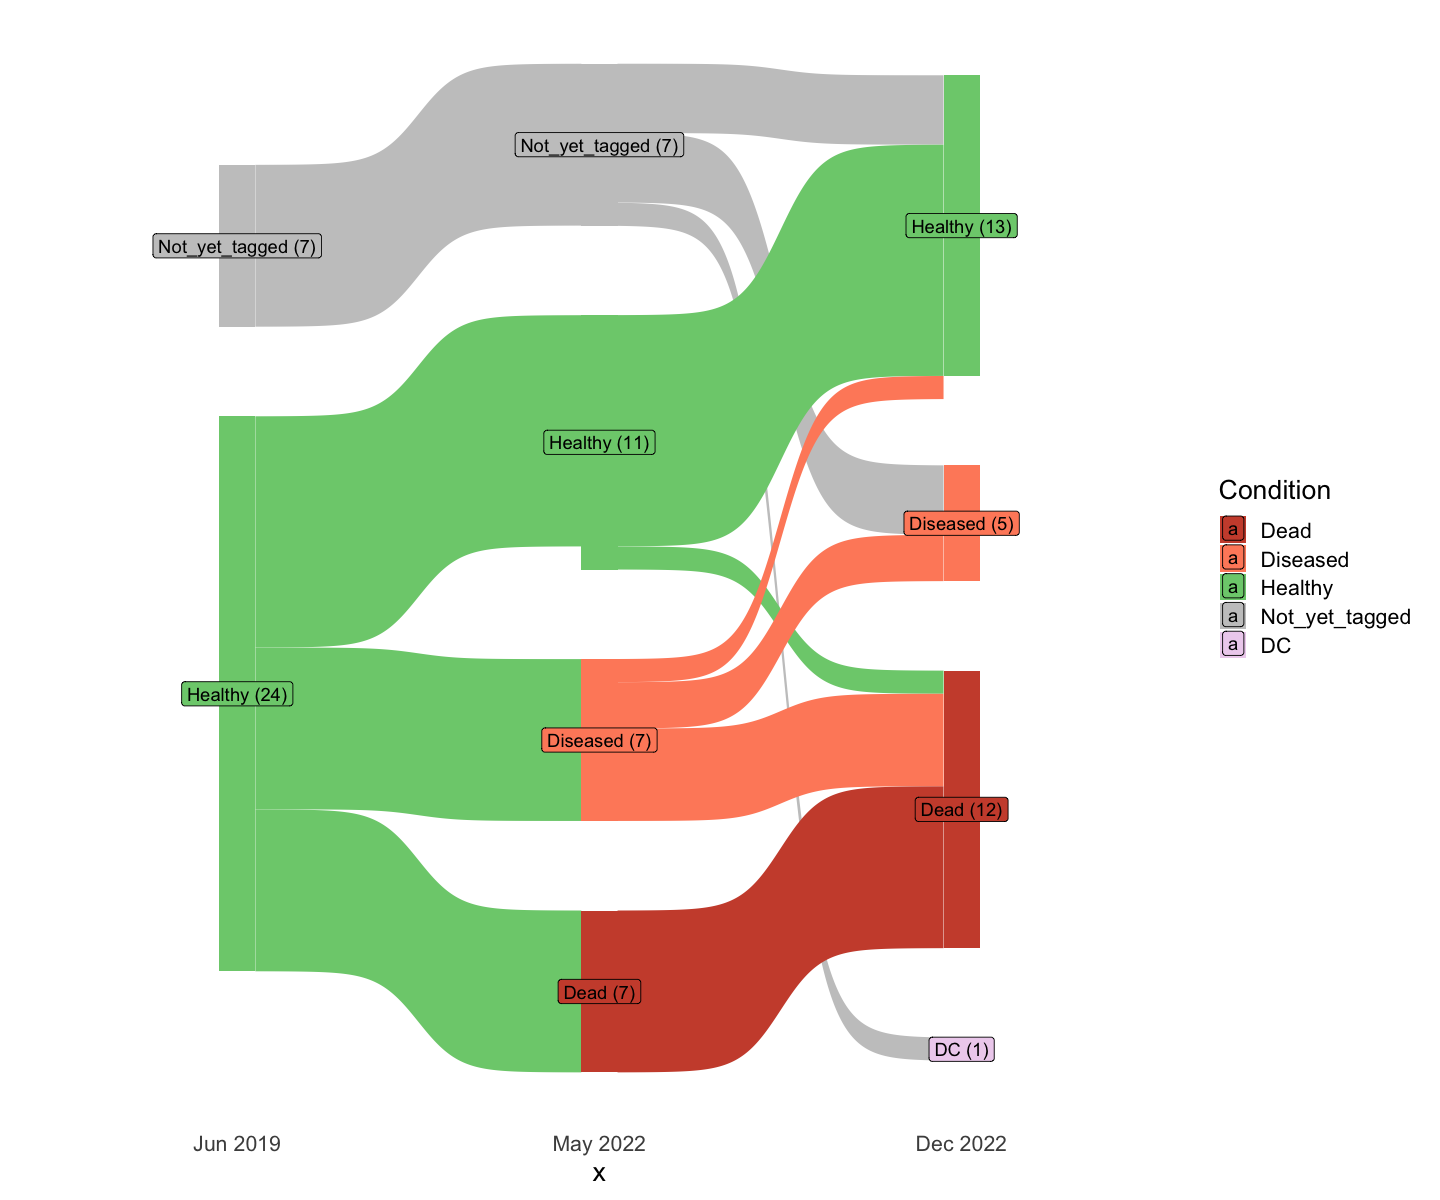

In [22]:
# add colony counts and custom colors 
ggplot(mcav, aes(x = x, 
               next_x = next_x, 
               node = node, 
               next_node = next_node,
               fill = factor(node),
               label = node)) +
  geom_sankey() +
  geom_sankey_label(aes(
      # colony counts 
       label = paste0(node, " (", after_stat(freq), ")")
  )
  ) +
  theme_sankey(base_size = 16) +
  scale_fill_manual("Condition", values = c(sank_colors))

# investigate DC - should we just call it healthy or diseased for our purposes?

# it starts and ends with 31 but there are 32 in may 2022??

In [23]:
# investigate any dups 
dupes <- mcav %>%
  count(x, colony_id) %>%
  filter(n > 1)
dupes

#remove 
mcav <- mcav %>%
  distinct(x, colony_id, .keep_all = TRUE)

x,colony_id,n
<fct>,<chr>,<int>
May 2022,T1_24_MCAV,2


In [24]:
# sample counts - exclude na as sample condition 
mcav_counts <- mcav %>%
  group_by(x, sample_condition) %>%
  mutate(n_samples = sum(!is.na(sample_condition))) %>%
  ungroup()
head(mcav_counts)

x,node,next_x,next_node,colony_id,sample_condition,species,n_samples
<fct>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>
Jun 2019,Healthy,May 2022,Healthy,T1_7_MCAV,Healthy,MCAV,24
May 2022,Healthy,Dec 2022,Healthy,T1_7_MCAV,Healthy,MCAV,9
Dec 2022,Healthy,NA,NA,T1_7_MCAV,Healthy,MCAV,14
Jun 2019,Healthy,May 2022,Diseased,T1_8_MCAV,Healthy,MCAV,24
May 2022,Diseased,Dec 2022,Diseased,T1_8_MCAV,Diseased,MCAV,6
Dec 2022,Diseased,NA,NA,T1_8_MCAV,Diseased,MCAV,5


In [25]:
mcav_counts<-mcav_counts %>%
    mutate(n_samples = if_else(
        node == "DC",
        1,
        n_samples
    ))

In [26]:
mcav_counts <- mcav_counts %>%
  group_by(x, node) %>%
  mutate(
    colony_count = n(),                 # same as after_stat(freq)
    label_text = paste0(node, "\n", 
                        colony_count, " colonies / ",
                        sample_condition, " ",
                        n_samples, " samples")
  ) %>%
  ungroup()

In [27]:
head(mcav_counts)

x,node,next_x,next_node,colony_id,sample_condition,species,n_samples,colony_count,label_text
<fct>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>
Jun 2019,Healthy,May 2022,Healthy,T1_7_MCAV,Healthy,MCAV,24,24,Healthy 24 colonies / Healthy 24 samples
May 2022,Healthy,Dec 2022,Healthy,T1_7_MCAV,Healthy,MCAV,9,10,Healthy 10 colonies / Healthy 9 samples
Dec 2022,Healthy,NA,NA,T1_7_MCAV,Healthy,MCAV,14,13,Healthy 13 colonies / Healthy 14 samples
Jun 2019,Healthy,May 2022,Diseased,T1_8_MCAV,Healthy,MCAV,24,24,Healthy 24 colonies / Healthy 24 samples
May 2022,Diseased,Dec 2022,Diseased,T1_8_MCAV,Diseased,MCAV,6,7,Diseased 7 colonies / Diseased 6 samples
Dec 2022,Diseased,NA,NA,T1_8_MCAV,Diseased,MCAV,5,5,Diseased 5 colonies / Diseased 5 samples


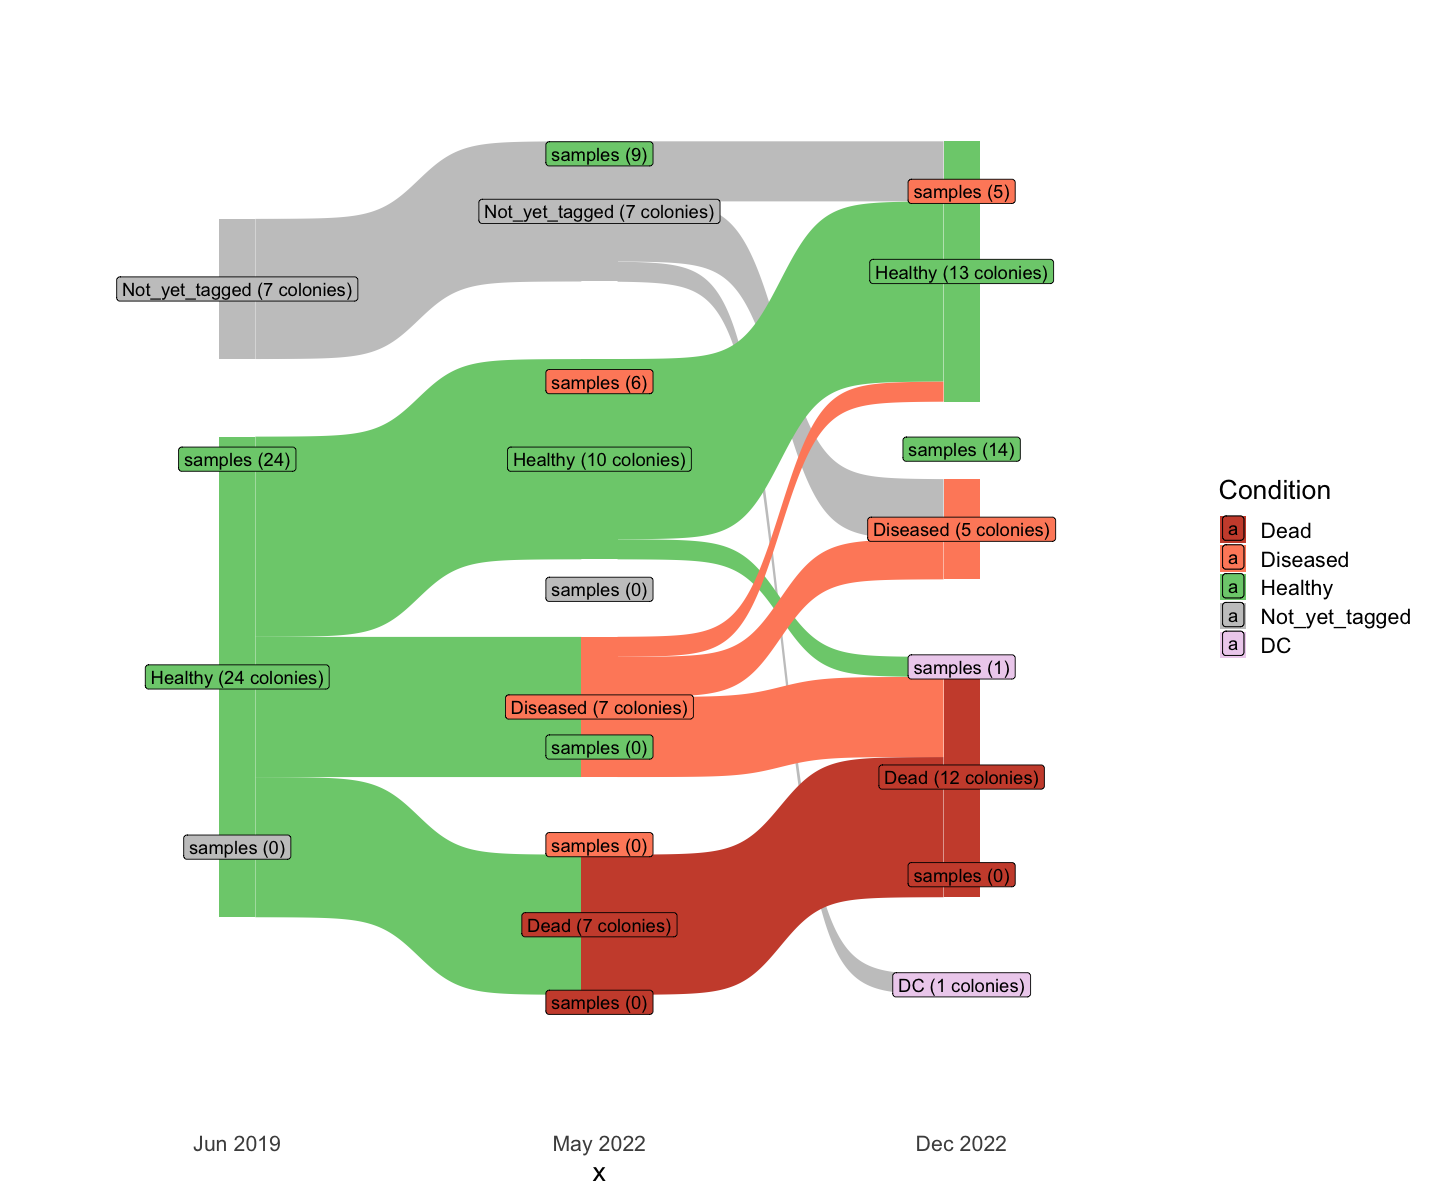

In [28]:
# add sample counts
ggplot(mcav_counts, aes(x = x, 
               next_x = next_x, 
               node = node, 
               next_node = next_node,
               fill = factor(node),
               label = node)) +
  geom_sankey() +
  geom_sankey_label(aes(
      # colony counts 
      label = paste0(node, " (", after_stat(freq), " colonies)")))+
                    # stagger labels
                    # vjust = -0.2) +

  geom_sankey_label(aes(
      # sample counts 
      label = paste0("samples", " (",n_samples,")")))+
                    # stagger labels 
                    # vjust = 0) +
  theme_sankey(base_size = 16) +
  scale_fill_manual("Condition", values = c(sank_colors))


# close but formatting is crazy 

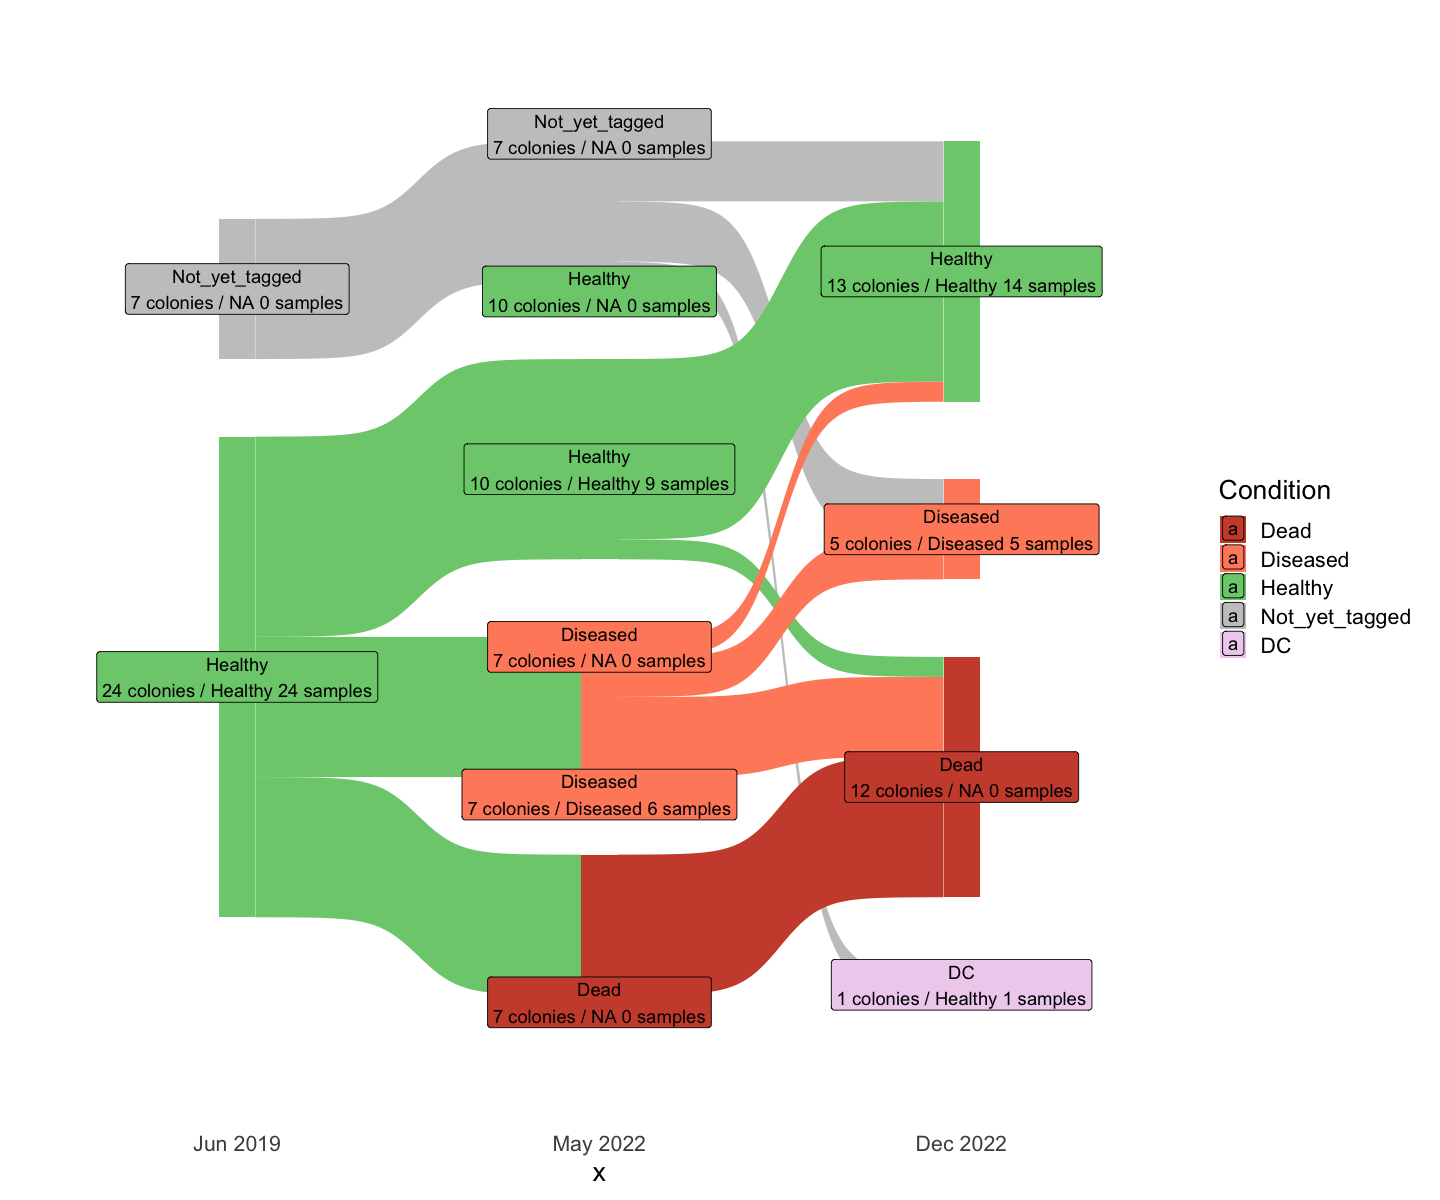

In [32]:
ggplot(mcav_counts, aes(x = x, next_x = next_x,
                        node = node, next_node = next_node,
                        fill = factor(node))) +
  geom_sankey() +
  geom_sankey_label(aes(label = label_text)) +
  theme_sankey(base_size = 16) +
  scale_fill_manual("Condition", values = sank_colors)

# almost..
# i think this works just need to get rid of the NA samples for non-NA colony conditions? 
# and then the only other problem is the healthy samples is 14 in healthy and 1 in DC but in reality its 14 total 


# somewhere add conditional statements: only print NA # of samples if the condition is not-yet-tagged or na
# print # of samples when sample_condition == node, if it doesn't match, print 0 # samples

In [33]:
ggplot(mcav_new, aes(x = x, 
               next_x = next_x, 
               node = node, 
               next_node = next_node,
               fill = factor(node),
               label = node)) +
  geom_sankey() +
  geom_sankey_label(aes(
      # colony counts 
       label = paste0(node, "\n(", after_stat(freq), " colonies)"))
                   ) +
  geom_sankey_label(aes(
      label = if_else(
          # don't show NA samples
          is.na(sample_condition),
          NA_character_,
          paste0(sample_condition, " ", n_sample, " samples")))
                    )+
  theme_sankey(base_size = 16) +
  scale_fill_manual("Condition", values = c(sank_colors))

ERROR: Error: object 'mcav_new' not found


In [ ]:
test_count<-mcav %>%
    group_by(x,node) %>%
    summarise(n_colony=n_distinct(colony_id),
             .groups = 'drop')

mcav_count_test <- mcav %>%
  left_join(test_count, by = c("x", "node"))

mcav_count_test2<-mcav %>%
    group_by(x,node,sample_condition) %>%
    summarise(n_sample=n())

mcav_new <- mcav_count_test %>%
  left_join(mcav_count_test2, by = c("x", "node","sample_condition")) %>%
    mutate(paste0())
head(mcav_new)



Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_label()`).”


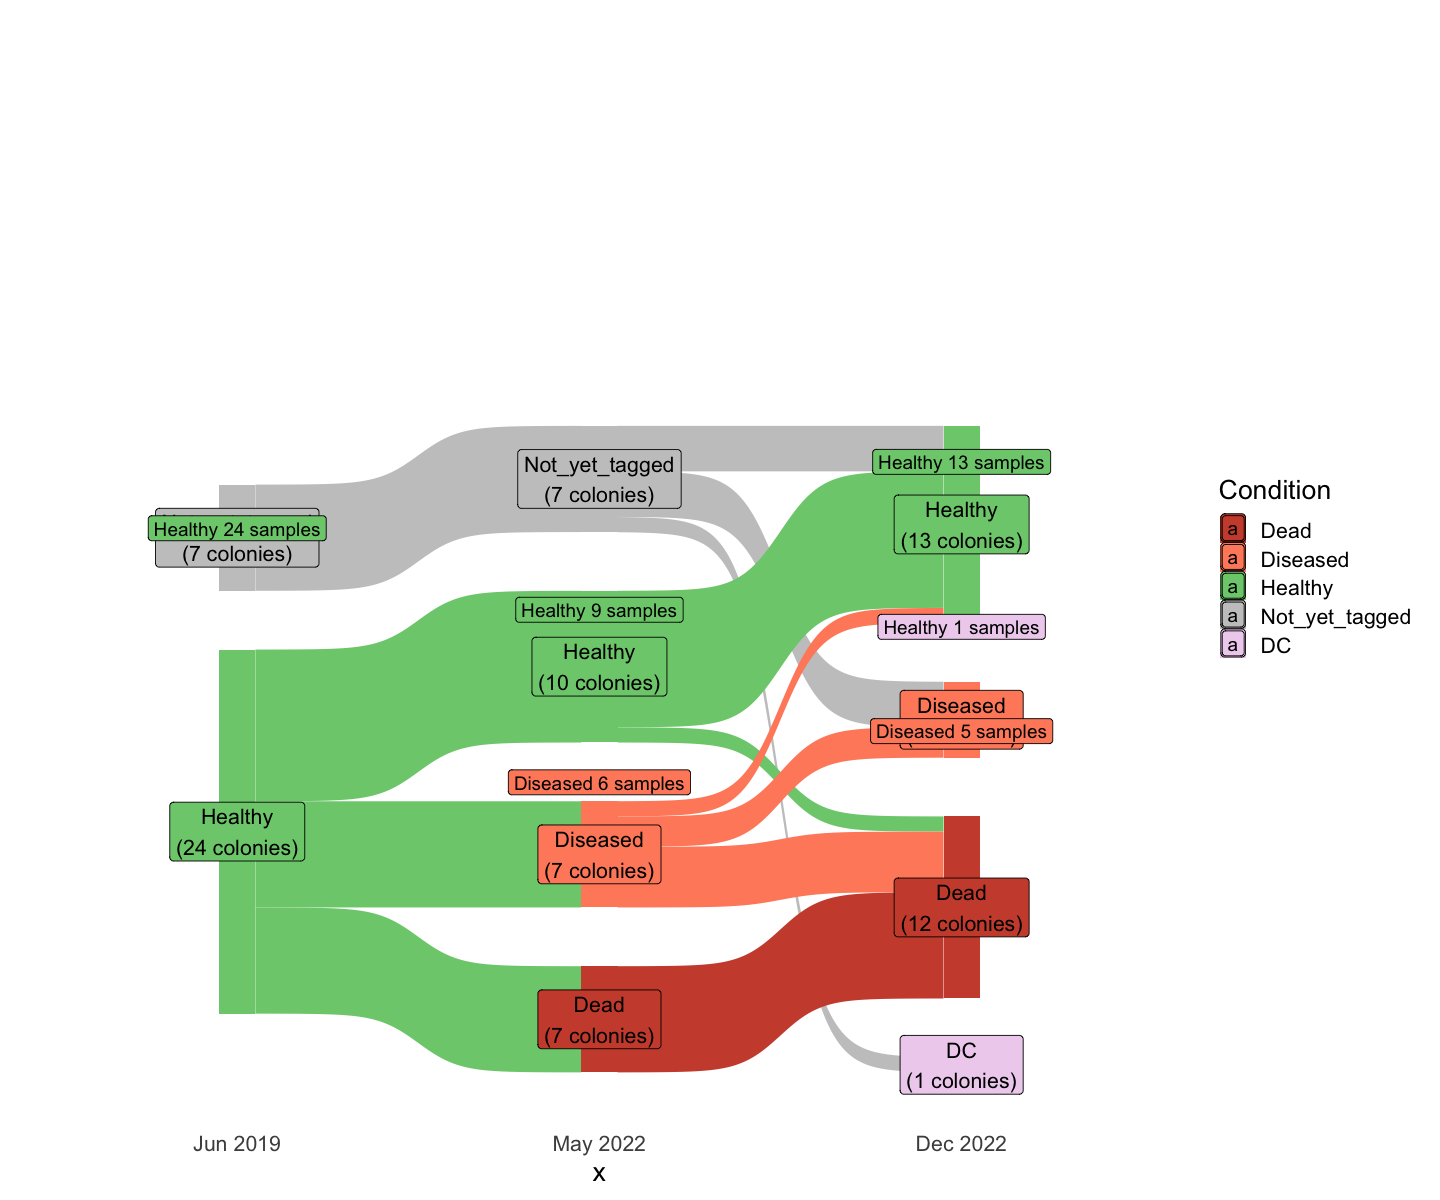

In [101]:


ggplot(mcav_new, aes(x = x, 
               next_x = next_x, 
               node = node, 
               next_node = next_node,
               fill = factor(node),
               label = node)) +
  geom_sankey() +
  geom_sankey_label(aes(
      # colony counts 
       label = paste0(node, "\n(", after_stat(freq), " colonies)")),
                   size = 4.5, 
                    #position = position_nudge(x = 0.1)#,
                    # space = 20
                   ) +
  geom_sankey_label(aes(
      label = if_else(
          # don't show NA samples
          is.na(sample_condition),
          NA_character_,
          paste0(sample_condition, " ", n_sample, " samples"))),
                    size = 4,
                    position = position_nudge(y = 20),
                    # space = 15 this moves it too much 
                   )+
  theme_sankey(base_size = 16) +
  scale_fill_manual("Condition", values = c(sank_colors))

# this works just cant figure out the spacing for the secondary label 

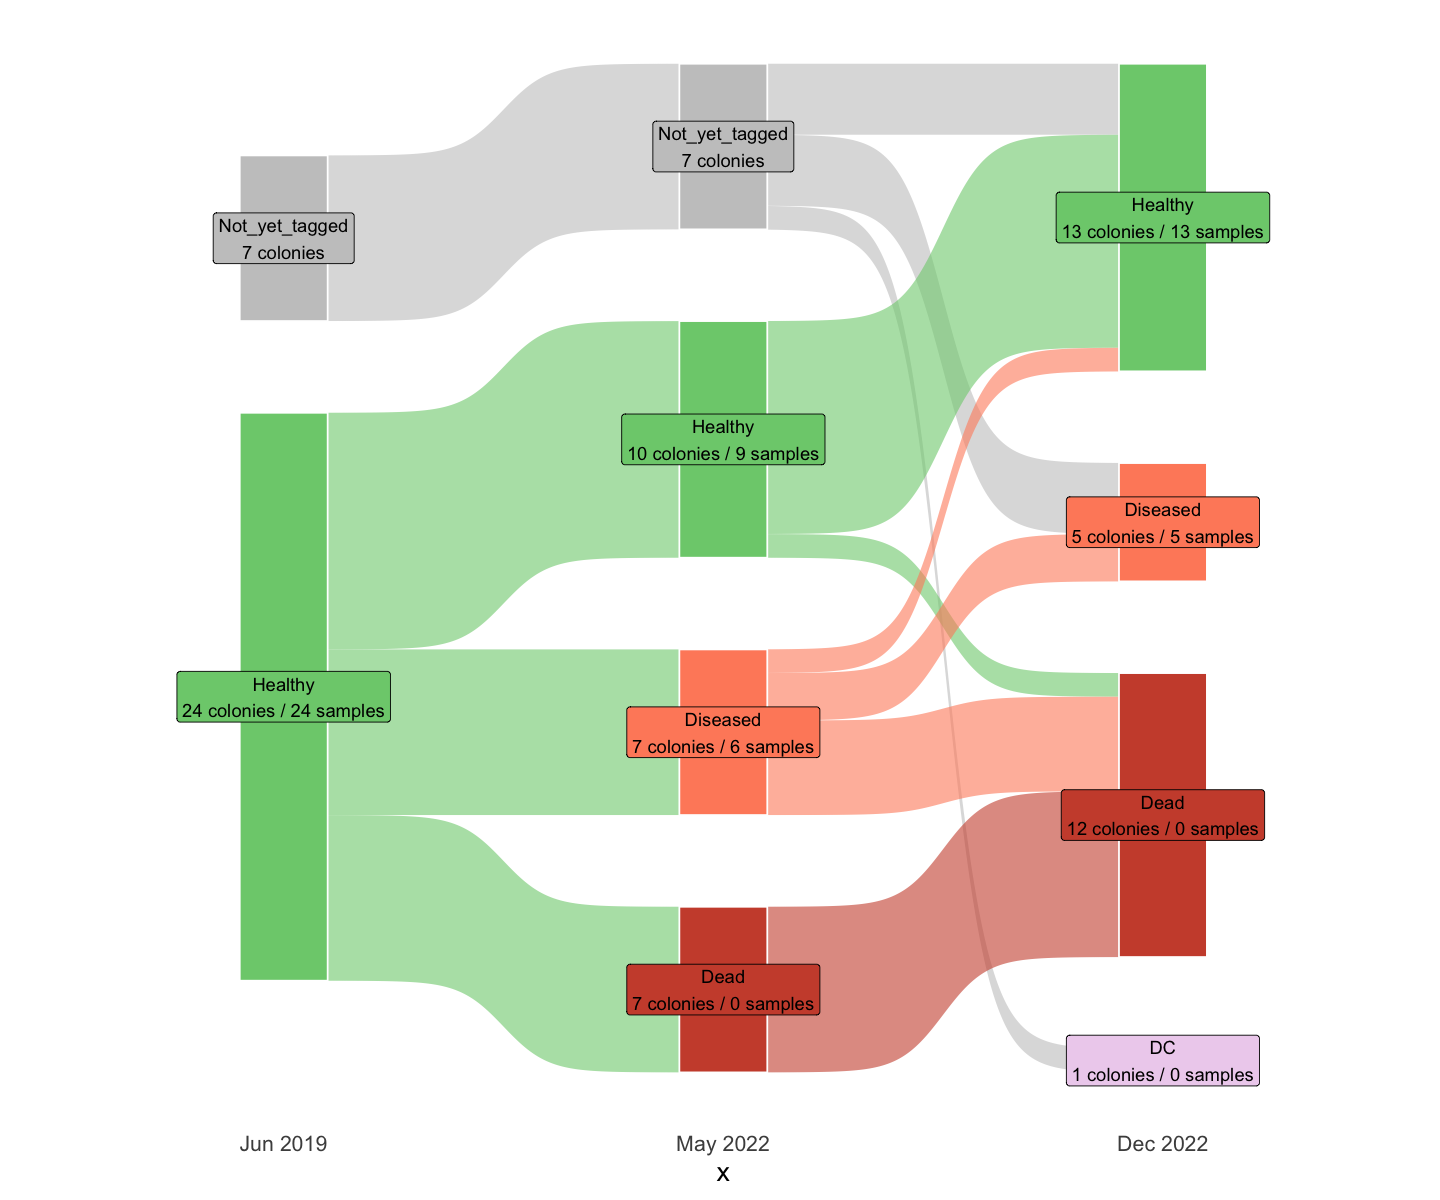

In [223]:
# compute colony and sample counts per node
# this is from chatgpt 
test <- mcav_counts %>%
  group_by(x, node) %>%
  mutate(
    colony_count = n(),                                  # number of colonies in this node
    sample_count = sum(sample_condition == node, na.rm = TRUE),  # samples that match node
    # optional: suppress sample count if node is Not_yet_tagged
    sample_count = ifelse(node %in% c("Not_yet_tagged", NA), NA, sample_count),
    # create label
    label_text = paste0(
      node, "\n",
      colony_count, " colonies",
      ifelse(!is.na(sample_count), paste0(" / ", sample_count, " samples"), "")
    )
  ) %>%
  ungroup()

# plot
ggplot(test, aes(x = x, next_x = next_x,
                        node = node, next_node = next_node,
                        fill = factor(node))) +
  geom_sankey(flow.alpha = 0.6, node.color = "white", width = 0.2) +
  geom_sankey_label(aes(label = label_text)) +
  scale_fill_manual(values = sank_colors) +
  theme_sankey(base_size = 16) +
  theme(legend.position = "none")
